Best model: 
Model          IForest
Scaler       Frequency
Min Ngram            7
Max Ngram            7
Score         0.960865
Name: 0, dtype: object


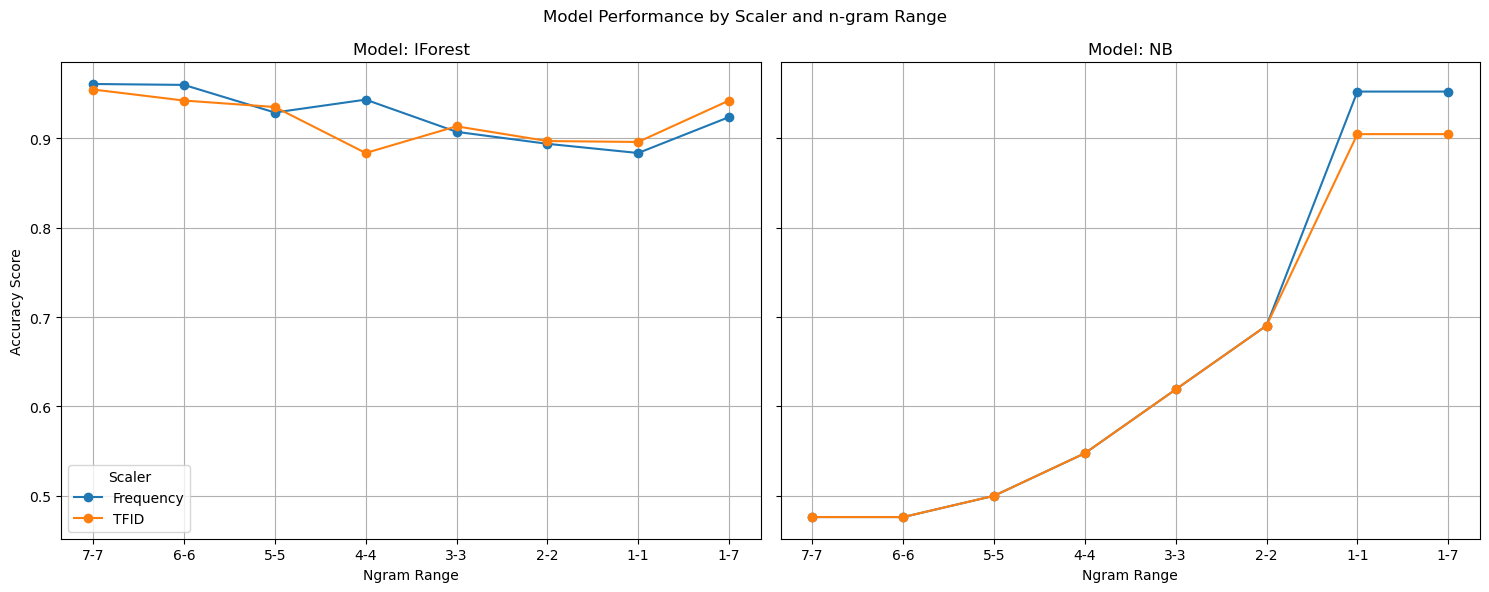

In [29]:
# V1
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=1, output_dir=models_dir)

# Create graph of accuracy per model
print("Best model: ")
print(model_score.iloc[0])

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
models = model_score['Model'].unique()
fig, axs = plt.subplots(1, len(models), figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, models):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str) + "-" + df_grouped['Max Ngram'].astype(str), 
                df_grouped['Score'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Ngram Range')
    if ax == axs[0]:
        ax.set_ylabel('Accuracy Score')
        ax.legend(title='Scaler')
    ax.grid(True)

plt.suptitle('Model Performance by Scaler and n-gram Range')

plt.tight_layout()
plt.show()


Best model: IForest_TFID_1_1 with score 0.9659863945578231


<Axes: title={'center': 'Model accuracy'}, xlabel='Model'>

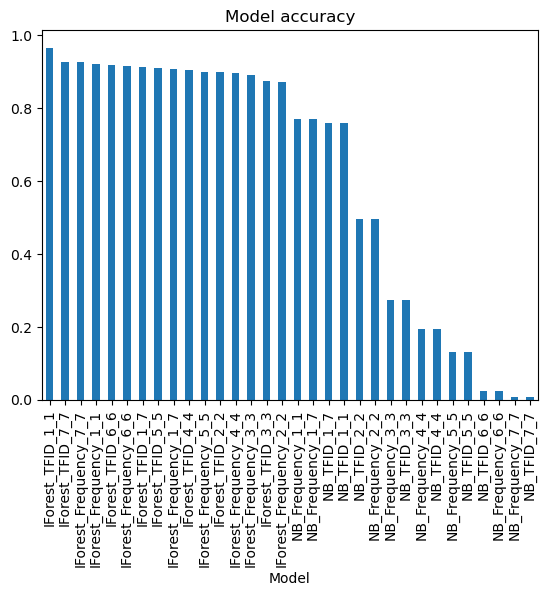

In [30]:
# V2
from log_reader import read_file, classify_malicious
from preprocessors.preprocessor import Preprocessor
from train_models import load_model
import os
import pandas as pd

ransim_file = '../logs/V2/malicious_RanSim_10min.log'
ransim_file = os.path.join(os.getcwd(), ransim_file)

df = read_file(ransim_file)
df = classify_malicious(df, os.path.basename(ransim_file))
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
model_files = filter(lambda x: x.endswith('.pkl'), os.listdir(models_dir))

models = [load_model(os.path.join(models_dir, model)) for model in model_files]

model_score = {}
for model in models:
    score = model.get_score(df['syscall'], df['malicious'])
    model_score[model] = score

# Create graph of accuracy per model
model_score = pd.DataFrame(list(model_score.items()), columns=['Model', 'Score'])
model_score = model_score.sort_values(by='Score', ascending=False)
print(f"Best model: {model_score.iloc[0]['Model']} with score {model_score.iloc[0]['Score']}")
model_score.plot(kind='bar', x='Model', y='Score', legend=False, title='Model accuracy')